In [73]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [96]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [82]:
from itertools import product
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [94]:
from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, words
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [77]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, f1_score

<a id='wrangling'></a>
## Data Wrangling

In this section we'll load the data, assess it to check for any quality or tidiness issues and clean where needed.

<a id='gather'></a>
### Gather

In [12]:
engine = create_engine('sqlite:///../crypto_db/db.sqlite3')
df_tweets = pd.read_sql_table('model_tweet', engine)
df_users = pd.read_sql_table('model_twitteruser', engine)

In [10]:
df_tweets.head()

,id,created_at,full_text,number_hashtags,number_symbols,user_mentions,number_urls,number_media,in_reply_to_status,has_quoted_status,retweet_count,favourite_count,reply_count,quote_count,possibly_sensitive,user_id,contributors
0,153357260385566720,2012-01-01 06:09:54,०ुूुूुू\n\nुूुूुूुू़ःEleusinian Mysteriesूुूुू...,0,0,0,0,0,False,False,0,0,0,0,False,64107706,None
1,153573419647123456,2012-01-01 20:28:51,Re: The rise and fall of bitcoin: Inside the v...,0,0,0,2,0,False,False,0,0,0,0,False,302899999,None
2,153579674952413184,2012-01-01 20:53:43,At my favorite BitCoin accepting bar in Berlin...,0,0,0,0,1,False,False,1,2,0,0,False,1147751,None
3,153620497127583745,2012-01-01 23:35:55,#Bitcoin is definitely back: 5.4$,1,0,0,0,0,False,False,2,1,0,1,False,18305304,None
4,328541159460835338,2013-04-28 16:08:11,http://t.co/iFVfkPUZ6Y found article on Heise...,1,0,0,1,0,False,False,0,0,0,0,False,157150170,None


In [11]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384601 entries, 0 to 384600
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  384601 non-null  object        
 1   created_at          384601 non-null  datetime64[ns]
 2   full_text           384601 non-null  object        
 3   number_hashtags     384601 non-null  int64         
 4   number_symbols      384601 non-null  int64         
 5   user_mentions       384601 non-null  int64         
 6   number_urls         384601 non-null  int64         
 7   number_media        384601 non-null  int64         
 8   in_reply_to_status  384601 non-null  bool          
 9   has_quoted_status   384601 non-null  bool          
 10  retweet_count       384601 non-null  int64         
 11  favourite_count     384601 non-null  int64         
 12  reply_count         384601 non-null  int64         
 13  quote_count         384601 no

In [13]:
df_users.head()

,name,location,description,followers_count,friends_count,listed_count,created_at,favourites_count,statuses_count,media_count,blocked_by,blocking,id
0,ビットコイン運用検査人,福岡県福岡市,ビットコインやブロックチェーン、仮想通貨に関する情報をお届け,3254,2700,86,2010-07-05 02:05:26,8,3833,5,False,False,162917619
1,Red Velvet Rick,"ÜT: 33.482815,-86.70846","Sports, jokes, music and Southern things.",7439,1573,248,2008-04-20 02:28:02,59250,93711,2150,False,False,14448426
2,NieL Bianconeri ☸♊ ☮,"Pune, India","Avant garde,\nEmpirical: A Message To #Humani...",299,522,0,2010-02-08 18:17:48,3129,27204,915,False,False,112495087
3,John W [Jan/3➞₿🔑∎],"Las Vegas, NV",#Crypto #Metal Trader (verify first).\nBitrate...,1176,2548,47,2007-05-24 13:29:53,1250,6909,832,False,False,6286792
4,Carlos Hernandez,,#BCH holder. Tweets are my own opinions. Not...,357,55,78,2011-02-26 02:25:23,698,14,90,False,False,257740771


In [14]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99961 entries, 0 to 99960
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              99961 non-null  object        
 1   location          99961 non-null  object        
 2   description       99961 non-null  object        
 3   followers_count   99961 non-null  int64         
 4   friends_count     99961 non-null  int64         
 5   listed_count      99961 non-null  int64         
 6   created_at        99961 non-null  datetime64[ns]
 7   favourites_count  99961 non-null  int64         
 8   statuses_count    99961 non-null  int64         
 9   media_count       99961 non-null  int64         
 10  blocked_by        99961 non-null  bool          
 11  blocking          99961 non-null  bool          
 12  id                99961 non-null  object        
dtypes: bool(2), datetime64[ns](1), int64(6), object(4)
memory usage: 8.6+ MB


In [19]:
df_tweets.groupby(df_tweets.created_at.dt.date).sum()

,number_hashtags,number_symbols,user_mentions,number_urls,number_media,in_reply_to_status,has_quoted_status,retweet_count,favourite_count,reply_count,quote_count,possibly_sensitive
created_at,,,,,,,,,,,,
2009-02-18,0,0,0,0,0,0,0,37,72,7,9,0
2011-05-27,2,0,0,0,0,0,0,1,1,0,0,0
2012-01-01,1,0,0,2,1,0,0,3,3,0,1,0
2012-05-07,0,0,0,0,0,0,0,52,14,2,0,0
2012-11-28,1,0,2,0,1,0,0,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-15,0,0,0,1,0,0,0,132,323,17,10,0
2021-02-16,5,0,0,1,1,0,0,9,19,3,0,0
2021-02-17,5,0,1,3,3,0,0,13,72,8,6,0


In [37]:
df_tweets["date"] = df_tweets.created_at.dt.date

In [38]:
df_tweets.head()

,id,created_at,full_text,number_hashtags,number_symbols,user_mentions,number_urls,number_media,in_reply_to_status,has_quoted_status,retweet_count,favourite_count,reply_count,quote_count,possibly_sensitive,user_id,contributors,text_aggr,date
0,153357260385566720,2012-01-01 06:09:54,०ुूुूुू\n\nुूुूुूुू़ःEleusinian Mysteriesूुूुू...,0,0,0,0,0,False,False,0,0,0,0,False,64107706,None,०ुूुूुू\n\nुूुूुूुू़ःEleusinian Mysteriesूुूुू...,2012-01-01
1,153573419647123456,2012-01-01 20:28:51,Re: The rise and fall of bitcoin: Inside the v...,0,0,0,2,0,False,False,0,0,0,0,False,302899999,None,०ुूुूुू\n\nुूुूुूुू़ःEleusinian Mysteriesूुूुू...,2012-01-01
2,153579674952413184,2012-01-01 20:53:43,At my favorite BitCoin accepting bar in Berlin...,0,0,0,0,1,False,False,1,2,0,0,False,1147751,None,०ुूुूुू\n\nुूुूुूुू़ःEleusinian Mysteriesूुूुू...,2012-01-01
3,153620497127583745,2012-01-01 23:35:55,#Bitcoin is definitely back: 5.4$,1,0,0,0,0,False,False,2,1,0,1,False,18305304,None,०ुूुूुू\n\nुूुूुूुू़ःEleusinian Mysteriesूुूुू...,2012-01-01
4,328541159460835338,2013-04-28 16:08:11,http://t.co/iFVfkPUZ6Y found article on Heise...,1,0,0,1,0,False,False,0,0,0,0,False,157150170,None,http://t.co/iFVfkPUZ6Y found article on Heise...,2013-04-28


In [55]:
summing_cols = ['number_hashtags', 'number_symbols',
       'user_mentions', 'number_urls', 'number_media',
       'retweet_count', 'favourite_count', 'reply_count',
       'quote_count']

by_date = df_tweets.groupby(df_tweets.date).agg({'full_text': lambda x: ' '.join(x), **{col: 'sum' for col in summing_cols}})
by_date

,full_text,number_hashtags,number_symbols,user_mentions,number_urls,number_media,retweet_count,favourite_count,reply_count,quote_count
date,,,,,,,,,,
2009-02-18,Just wrote: Bitcoin: new open source P2P e-cas...,0,0,0,0,0,37,72,7,9
2011-05-27,Preparing for CSIS seminar today. Final choice...,2,0,0,0,0,1,1,0,0
2012-01-01,०ुूुूुू\n\nुूुूुूुू़ःEleusinian Mysteriesूुूुू...,1,0,0,2,1,3,3,0,1
2012-05-07,at da end of da day most of yo mans aint reall...,0,0,0,0,0,52,14,2,0
2012-11-28,"#smwf @sprinkler @Socialatscale ""Social is hum...",1,0,2,0,1,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...
2021-02-15,Many displaced families have faced another bru...,0,0,0,1,0,132,323,17,10
2021-02-16,Can projected #LPG demand in the #EU be met en...,5,0,0,1,1,9,19,3,0
2021-02-17,We are glad to announce the confirmed speakers...,5,0,1,3,3,13,72,8,6


In [69]:
by_date.iloc[by_date["favourite_count"].argmax()]["full_text"]

'[Bitcoin Trading] AdamBs [WTS] 8bitcoins UK Seller. Trade/Sell/Buy this item: http://t.co/veb53b6NeX #bitcoin Charlie Shrem and Richard Stallman to Speak at Central European Bitcoin Expo http://t.co/294zDKFBIX Check Out Who\'s Investing in Bitcoin Now: In his thousands of hours of number-crunching, editor Sid R... http://t.co/J5yyedJwK2 #bitcoin We\'re so excited to attend the premiere of The Rise and Rise of #Bitcoin! A sold out event! http://t.co/t1tEzVJ0Eu #BitcoinDoc #TFF2014 Jean Paul Gaultier and Jennifer Saunders\' \'French and Saunders\' sketch http://t.co/mTs0OuVCAL Pls Rt #Bitcoin : bitcoin price at date Fri, 11 Apr 2014 17:58:53 -0600  . provided by http://t.co/S3lSCz92Gj - donations for b...  http://t.co/8gnMImLl2y Bitcoin Sheds Over 10%, Falls Below $400 http://t.co/qUE31i95sA Bullish on Bitcoin: These Travel Companies Want Your Virtual Money: Bitcoin -- the alternative currency create... http://t.co/IXg6zZdBBi BitInvest’s Coincard is a Prepaid MasterCard for #Bitcoin Lov

In [70]:
by_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625 entries, 2009-02-18 to 2021-02-19
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   full_text        625 non-null    object
 1   number_hashtags  625 non-null    int64 
 2   number_symbols   625 non-null    int64 
 3   user_mentions    625 non-null    int64 
 4   number_urls      625 non-null    int64 
 5   number_media     625 non-null    int64 
 6   retweet_count    625 non-null    int64 
 7   favourite_count  625 non-null    int64 
 8   reply_count      625 non-null    int64 
 9   quote_count      625 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 53.7+ KB


**Crypto Data**

In [71]:
df = pd.read_csv('../data/bitcoin_data.csv')

In [72]:
df.head()

,index,currency,date,open,high,low,close,volume,market_cap,change,...,close_smsd_99,upper,lower,volatility,target,target_class,multi_target_class,weekday,month,target_class_cat
0,5579,bitcoin,2013-04-28,135.30,135.98,132.10,134.21,NaN,1.488567e+09,-0.008056,...,NaN,NaN,NaN,0.028534,0.075126,1,1,Sun,Apr,upper
1,5578,bitcoin,2013-04-29,134.44,147.49,134.00,144.54,NaN,1.603769e+09,0.075126,...,NaN,NaN,NaN,0.091464,-0.034722,0,-1,Mon,Apr,lower
2,5577,bitcoin,2013-04-30,144.00,146.93,134.05,139.00,NaN,1.542813e+09,-0.034722,...,NaN,NaN,NaN,0.087661,-0.158345,0,-1,Tue,Apr,lower
3,5576,bitcoin,2013-05-01,139.00,139.89,107.72,116.99,NaN,1.298955e+09,-0.158345,...,NaN,NaN,NaN,0.229966,-0.095979,0,-1,Wed,May,lower
4,5575,bitcoin,2013-05-02,116.38,125.60,92.28,105.21,NaN,1.168517e+09,-0.095979,...,NaN,NaN,NaN,0.265287,-0.080000,0,-1,Thu,May,lower


<a id='helper_classes'></a>
## Helper Classes & Methods

In [228]:
def feature_mapping(x, order, intercept=False, only_self_terms=False):
    """
    Maps the original features up to the chosen degree.
    Example for initial features a and b and chosen order of 3:
    [a b a^2 ab b^2 a^3 a^2b ab^2 b^3]
    :param x: array like object of m examples by n features
    :param order: order of the polynomial expansion mapping to perform
    :param intercept: If return array should include the intercept column
    :param only_self_terms: if should only include polynomial terms (eg: x, x2, x3, etc)
    :return: array with mapped features
    """
    X = np.array(x).copy()

    n_features = X.shape[1] if len(X.shape) > 1 else 1
    features = [i for i in range(n_features)]

    for i in range(2, order + 1):

        if only_self_terms:

            for j in features:
                # X = np.hstack((X, X[:, j] ** i))
                X = np.c_[X, X[:, j] ** i]

        else:
            product_cases = list(product(features, repeat=i))

            product_cases = [tuple(sorted(t)) for t in product_cases]
            product_cases = list(set(product_cases))

            for case in product_cases:

                columns = np.array([x[:, int(col)] for col in case]).T
                columns_prod = np.cumprod(columns, axis=1)[:, -1].reshape(-1, 1)

                X = np.hstack((X, columns_prod))

    if intercept:
        X = np.c_[np.ones(X.shape[0]), X]

    return X

In [229]:
def plot_learning_curve(estimator, title, X, y, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 1.0, 10),
                        metric='neg_mean_squared_error'
                       ):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(8, 18))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, 
                       scoring=metric
                      )
    
    train_scores = np.abs(train_scores)
    test_scores = np.abs(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation error")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Error")
    axes[2].set_title("Performance of the model")

    return train_sizes, train_scores, test_scores, fit_times

In [230]:
class FeaturePolynomial(BaseEstimator, TransformerMixin):
    """
    Returns the polynomial terms of features up to a specified degree.
    """
    
    def __init__(self, order, only_self_terms=True):
        self.order = order
        self.only_self_terms = only_self_terms
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        try:
            poly_X = feature_mapping(X.to_numpy(), self.order, only_self_terms=self.only_self_terms)
        except AttributeError:
            poly_X = feature_mapping(X, self.order, only_self_terms=self.only_self_terms)
        
        return poly_X

In [125]:
def tokenize(text, include_numbers=True):
    
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    text = re.sub(url_pattern, 'urlplaceholder', text)
        
    pattern = r'[^a-zA-Z0-9]' if include_numbers else r'[^a-zA-Z]'
    
    text = re.sub(pattern, ' ', text)
        
    pattern = r'[0-9]+'
    
    text = re.sub(pattern, 'numberplaceholder', text)
        
    words = word_tokenize(text)
    
    words = [stemmer.stem(lemmatizer.lemmatize(word.lower().strip())) for word in words if word not in stop_words]
    words = [word for word in words if word in words_set]
    
    return words

<a id='feature_engineering'></a>
## Feature Engineering

In [126]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

In [127]:
words_set = set(nltk.corpus.words.words())

In [128]:
text = by_date.iloc[by_date["favourite_count"].argmax()]["full_text"]

In [129]:
tokenize(text)

['trade',
 'seller',
 'trade',
 'sell',
 'buy',
 'item',
 'stallman',
 'speak',
 'central',
 'check',
 'out',
 'who',
 'invest',
 'now',
 'in',
 'thousand',
 'hour',
 'number',
 'crunch',
 'editor',
 'r',
 'we',
 'attend',
 'premier',
 'the',
 'rise',
 'rise',
 'a',
 'sold',
 'event',
 'jean',
 'sketch',
 'price',
 'date',
 'b',
 'shed',
 'over',
 'fall',
 'below',
 'bullish',
 'these',
 'travel',
 'want',
 'your',
 'virtual',
 'money',
 'altern',
 'creat',
 'lover',
 'lead',
 'brazil',
 'base',
 'digit',
 'the',
 'group',
 'live',
 'sport',
 'via',
 'fatal',
 'flaw',
 'transact',
 'they',
 'never',
 'undon',
 'could',
 'use',
 'new',
 'chair',
 'screen',
 'ur',
 'come',
 'hill',
 'time',
 'i',
 'thing',
 'tor',
 'watcher',
 'i',
 'would',
 'think',
 'junk',
 'coin',
 'good',
 'hello',
 'we',
 'accept',
 'alto',
 'come',
 'soon',
 'almost',
 'yesterday',
 'loss',
 'buy',
 'digit',
 'market',
 'coca',
 'cola',
 'net',
 'porter',
 'digit',
 'brand',
 'ma',
 'scoop',
 'alt',
 'coin',
 'tr

In [130]:
count_vectorizer = CountVectorizer(tokenizer=tokenize)
count = count_vectorizer.fit_transform(by_date["full_text"])

In [118]:
count_vectorizer.get_feature_names()

['aa',
 'aam',
 'aba',
 'abacus',
 'abandon',
 'abb',
 'abba',
 'abbey',
 'abbot',
 'abbrevi',
 'abduct',
 'abe',
 'aberr',
 'abhor',
 'abi',
 'abid',
 'abigail',
 'abil',
 'abir',
 'abject',
 'abl',
 'ablaz',
 'abnorm',
 'aboard',
 'abod',
 'abolish',
 'abolit',
 'abolitionist',
 'aborigin',
 'abort',
 'abound',
 'aboveground',
 'abracadabra',
 'abraxa',
 'abreast',
 'abridg',
 'abroad',
 'abrupt',
 'abscond',
 'absenc',
 'absent',
 'absinth',
 'absolut',
 'absorb',
 'abstain',
 'abstract',
 'abstrus',
 'absurd',
 'abu',
 'abund',
 'abus',
 'abut',
 'abuzz',
 'abysm',
 'abyss',
 'academ',
 'academi',
 'acara',
 'acca',
 'acced',
 'acceler',
 'accent',
 'accentu',
 'accept',
 'acceptor',
 'access',
 'accessori',
 'accid',
 'accident',
 'acclaim',
 'accolad',
 'accommod',
 'accompani',
 'accomplic',
 'accomplish',
 'accord',
 'accost',
 'account',
 'accredit',
 'accru',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'accusatori',
 'accustom',
 'ace',
 'ach',
 'achiev',
 'acid',
 'acknowl

In [117]:
len(count_vectorizer.get_feature_names())

15382

In [124]:
count[0:2, 0:10]

<2x10 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

<a id='model_training'></a>
## Model Training

In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               2188 non-null   int64         
 1   currency            2188 non-null   object        
 2   date                2188 non-null   datetime64[ns]
 3   open                2188 non-null   float64       
 4   high                2188 non-null   float64       
 5   low                 2188 non-null   float64       
 6   close               2188 non-null   float64       
 7   volume              1945 non-null   float64       
 8   market_cap          2188 non-null   float64       
 9   change              2188 non-null   float64       
 10  change_perc         2188 non-null   float64       
 11  number_coins        2188 non-null   float64       
 12  close_sma_7         2182 non-null   float64       
 13  close_sma_25        2164 non-null   float64     

In [434]:
model_features = ['open', 'close', 'volume', 'market_cap', 'change', 'close_sma_7',
                 'close_sma_25', 'close_sma_99', 'volume_sma_7', 'volume_sma_25', 'volume_sma_99',
                 'close_smsd_7', 'close_smsd_25', 'close_smsd_99', 'volatility']

model_target = 'multi_target_class'

In [435]:
df_model = df.copy()[[*model_features, model_target]]

In [436]:
df_model.dropna(axis=0, inplace=True)

In [437]:
X = df_model[model_features]
y = df_model[model_target]

In [438]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [439]:
pipeline = Pipeline([
#     ('feature_pol', FeaturePolynomial(3, False)),
    ('scaling', StandardScaler()),
    ('clf', GradientBoostingClassifier()),
])

In [440]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('clf', GradientBoostingClassifier())])

In [441]:
pipeline.score(X_test, y_test)

0.4189189189189189

In [442]:
X_test.iloc[0]

open             5.962000e+02
close            6.028400e+02
volume           5.106700e+07
market_cap       9.575632e+09
change           1.113720e-02
close_sma_7      6.042400e+02
close_sma_25     6.036240e+02
close_sma_99     6.249999e+02
volume_sma_7     5.917936e+07
volume_sma_25    7.248670e+07
volume_sma_99    1.067180e+08
close_smsd_7     5.648911e+00
close_smsd_25    1.455510e+01
close_smsd_99    4.522919e+01
volatility       1.230086e-02
Name: 1244, dtype: float64

In [443]:
print(y_test.iloc[0:10])
pipeline.predict(X_test.iloc[0:10])

1244    0
1463    1
484     1
1071    0
1345    1
399     1
1567    1
367     1
2130    0
1311    1
Name: multi_target_class, dtype: int64


array([ 0,  1, -1,  0,  1,  1,  1,  1,  1,  0])

In [444]:
y_pred = pipeline.predict(X_test)

In [445]:
f1_score(y_test, y_pred, average='weighted')

0.40897832818983904

In [446]:
recall_score(y_test, y_pred, average='weighted')

0.4189189189189189

In [447]:
precision_score(y_test, y_pred, average='weighted')

0.4159989288665567

In [448]:
confusion_matrix(y_test, y_pred)

array([[43, 15, 89],
       [23, 25, 24],
       [37, 27, 87]])

In [449]:
X_train.columns

Index(['open', 'close', 'volume', 'market_cap', 'change', 'close_sma_7',
       'close_sma_25', 'close_sma_99', 'volume_sma_7', 'volume_sma_25',
       'volume_sma_99', 'close_smsd_7', 'close_smsd_25', 'close_smsd_99',
       'volatility'],
      dtype='object')

In [450]:
pipeline["clf"].feature_importances_

array([0.04456252, 0.03400232, 0.10649923, 0.04081846, 0.09421942,
       0.04151915, 0.08616173, 0.05004577, 0.03905425, 0.03701552,
       0.05797265, 0.10286122, 0.05777726, 0.06385468, 0.14363582])

In [451]:
pd.DataFrame(pipeline["clf"].feature_importances_, index=X_train.columns)

,0
open,0.044563
close,0.034002
volume,0.106499
market_cap,0.040818
change,0.094219
close_sma_7,0.041519
close_sma_25,0.086162
close_sma_99,0.050046
volume_sma_7,0.039054
volume_sma_25,0.037016


In [226]:
parameters = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth': [None, 1, 5, 10]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

In [227]:
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('clf', GradientBoostingClassifier())]),
             param_grid={'clf__max_depth': [None, 1, 5, 10],
                         'clf__max_features': ['auto', 'sqrt', 'log2'],
                         'clf__n_estimators': [100, 200, 500]})

In [231]:
print(f"best estimator: {cv.best_estimator_}")
print(f"best params: {cv.best_params_}")
print(f"best score: {cv.best_score_}")

best estimator: Pipeline(steps=[('scaling', StandardScaler()),
                ('clf',
                 GradientBoostingClassifier(max_depth=1, max_features='auto',
                                            n_estimators=500))])
best params: {'clf__max_depth': 1, 'clf__max_features': 'auto', 'clf__n_estimators': 500}
best score: 0.6059688502061384


In [357]:
print(np.array([y_test.iloc[10:20]]))
pipeline.predict(X_test.iloc[10:20])

[[ 0  0 -1  0  1  0  0  1  0  0]]


array([ 0,  0, -1,  0,  0,  0,  0, -1,  0,  0])

In [311]:
pipeline = Pipeline([
    ('feature_pol', FeaturePolynomial(2, False)),
    ('scaling', StandardScaler()),
    ('clf', GradientBoostingClassifier(max_depth=1, max_features='auto', n_estimators=200)),
])

In [312]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_pol',
                 FeaturePolynomial(only_self_terms=False, order=2)),
                ('scaling', StandardScaler()),
                ('clf',
                 GradientBoostingClassifier(max_depth=1, max_features='auto',
                                            n_estimators=200))])

In [378]:
pipeline.score(X_test, y_test)

0.44594594594594594

In [314]:
print(np.array([y_test.iloc[0:10]]))
pipeline.predict(X_test.iloc[0:10])

[[ 1  0 -1  0  1  0  0  0  0 -1]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [315]:
y_pred = pipeline.predict(X_test)

In [316]:
f1_score(y_test, y_pred, average='micro')

0.6459459459459459

In [317]:
df_results = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

In [318]:
df_diff = df_results[df_results['y_pred'] != df_results['y_test']]
len(df_diff)

131

In [319]:
df_diff[df_diff['y_pred'] == 0]

,y_pred,y_test
2036,0,1
1655,0,-1
620,0,1
934,0,-1
944,0,1
...,...,...
1532,0,-1
1821,0,1
1955,0,-1
1905,0,1


In [320]:
y_pred = pipeline.predict(X_train)

f1_score(y_train, y_pred, average='micro')

0.6580907244414353

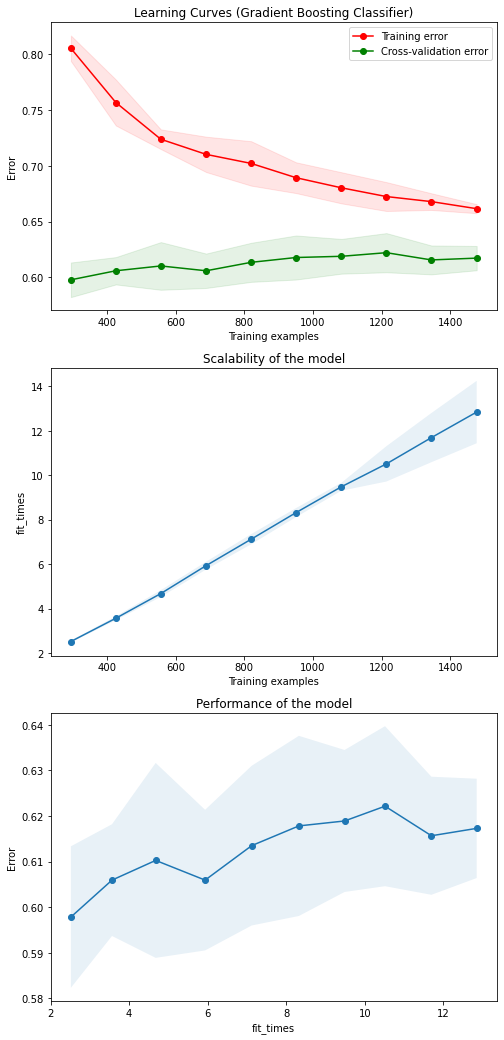

In [321]:
title = "Learning Curves (Gradient Boosting Classifier)"

cv = ShuffleSplit(n_splits=5, test_size=0.2)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(pipeline, title, X, y, cv=cv, train_sizes=np.linspace(0.2, 1, 10), metric='accuracy')